## Prepare

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../src/')

In [2]:
from package.logger import setup
setup("INFO")

In [3]:
import os

import folium

from package import strtime
from package.mcr5.h3 import (
    plot_h3_cells_on_folium,
)
from package.mcr5.labels import read_labels_for_nodes
from package.geometa import GeoMeta
from package.mcr.data import NetworkType, OSMData
import pandas as pd

In [4]:
geo_meta_path = "../data/geometa.pkl"
city_id = "Koeln"
stops = "../data/cleaned/stops.csv"
structs = "../data/structs.pkl"

geo_meta = GeoMeta.load(geo_meta_path)
geo_data = OSMData(
	geo_meta,
	city_id,
	additional_network_types=[NetworkType.DRIVING],
)
nodes = geo_data.osm_nodes
edges = geo_data.osm_edges
driving_nodes, _, _ = geo_data.additional_networks[NetworkType.DRIVING]

[20:03:20] INFO     Using existing OSM data                                                              ]8;id=760721;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/osm/osm.py\osm.py]8;;\:]8;id=294071;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/osm/osm.py#106\106]8;;\

           INFO     Loading OSM network from cache (walking)                                              ]8;id=349638;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/osm/osm.py\osm.py]8;;\:]8;id=656606;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/osm/osm.py#69\69]8;;\

[20:04:29] INFO     Using existing OSM data                                                              ]8;id=432445;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/osm/osm.py\osm.py]8;;\:]8;id=208166;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/osm/osm.py#106\106]8;;\

           INFO     Loading OSM network from cache (driving)                                              ]8;id=623846;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/osm/osm.py\osm.py]8;;\:]8;id=84395;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/osm/osm.py#69\69]8;;\

## Fetch POIs

In [5]:
import matplotlib.pyplot as plt
from package.minute_city import minute_city

In [6]:
pois = minute_city.fetch_pois_for_area(geo_meta.boundary, nodes)
pois.head(3)

name         id         lat        lon  \
0        Trink & Spare  263442909  51.0268777  6.8879464   
1       Weinhaus Linke  444820559  50.9543812  6.9189388   
2  O'Donnell Moonshine  448400534  50.9382394  6.9408967   

                   geometry     type  nearest_osm_node_id   distance  
0  POINT (6.88795 51.02688)  grocery           9007727500  21.098025  
1  POINT (6.91894 50.95438)  grocery           3890235659  13.327476  
2  POINT (6.94090 50.93824)  grocery           6513219752  16.685454

## Visualize POIs

In [7]:
# def rgb2hex(rgb):
# 	return "#{:02x}{:02x}{:02x}".format(int(rgb[0] * 255), int(rgb[1] * 255), int(rgb[2] * 255))
# types = pois["type"].unique()

# types = ['grocery', 'education', 'health', 'banks', 'parks', 'sustenance', 'shops']

# # Get a colormap and create a color mapping
# colormap = plt.colormaps.get_cmap('tab10')
# color_mapping = {type_: rgb2hex(colormap(i)) for i, type_ in enumerate(types)}
# color_mapping

# bbox = nodes.unary_union.convex_hull.bounds

# m = folium.Map(location=[50.9375, 6.9603], zoom_start=12)
# geo_meta.add_to_folium_map(m)
# for _, poi in pois.iterrows():
# 	folium.CircleMarker(
# 		location=(poi.lat, poi.lon),
# 		popup=poi["name"],
# 		radius=1,
# 		color=color_mapping[poi["type"]]
# 	).add_to(m)

# m

## Calculate 15-minute-city metric

In [8]:
mcr5_output_path = "../data/mcr5/Koeln"

In [9]:
labels_per_scenario = {}
for entry in os.scandir(mcr5_output_path):
    if not entry.is_dir():
        continue

    labels = read_labels_for_nodes(
        entry.path, pois.nearest_osm_node_id.unique()
    )

    labels = minute_city.add_pois_to_labels(labels, pois)
    labels_per_scenario[entry.name] = labels


In [10]:
labels_per_scenario["car"].head(3)

target_id_osm   time  cost  n_transfers human_readable_time  \
0     2343510804  28866    38            1            08:01:06   
1     2343510804  28866    38            1            08:01:06   
2     2343510804  28866    38            1            08:01:06   

      start_id_hex  nearest_osm_node_id  grocery  education  health  banks  \
0  891fa1983dbffff           2343510804        1          0       0      0   
1  891fa1983dbffff           2343510804        0          0       0      0   
2  891fa1983dbffff           2343510804        0          0       0      0   

   parks  sustenance  shops  
0      0           0      0  
1      0           0      1  
2      0           0      1

In [11]:
types = list(pois["type"].unique())

In [12]:
profiles_df_per_scenario = {}
for scenario, labels in labels_per_scenario.items():
	profiles_df_per_scenario[scenario] = minute_city.get_profiles_df(labels, types)

[20:05:17] INFO     Grouping labels                                                               ]8;id=895289;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/minute_city/minute_city.py\minute_city.py]8;;\:]8;id=989961;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/minute_city/minute_city.py#73\73]8;;\

           INFO     Grouping labels done (0.16 seconds)                                           ]8;id=739513;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/minute_city/minute_city.py\minute_city.py]8;;\:]8;id=740980;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/minute_city/minute_city.py#73\73]8;;\

           INFO     Calculating profiles                                                          ]8;id=159065;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/minute_city/minute_city.py\minute_city.py]8;;\:]8;id=51079;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/minute_city/minute_city.py#81\81]8;;\

  0%|          | 0/1750 [00:00<?, ?it/s]

[20:05:23] INFO     Calculating profiles done (5.38 seconds)                                      ]8;id=621567;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/minute_city/minute_city.py\minute_city.py]8;;\:]8;id=269906;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/minute_city/minute_city.py#81\81]8;;\

           INFO     Creating profiles dataframe                                                   ]8;id=953458;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/minute_city/minute_city.py\minute_city.py]8;;\:]8;id=748075;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/minute_city/minute_city.py#92\92]8;;\

           INFO     Creating profiles dataframe done (0.62 seconds)                               ]8;id=949294;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/minute_city/minute_city.py\minute_city.py]8;;\:]8;id=566312;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/minute_city/minute_city.py#92\92]8;;\

           INFO     Grouping labels                                                               ]8;id=913672;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/minute_city/minute_city.py\minute_city.py]8;;\:]8;id=418467;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/minute_city/minute_city.py#73\73]8;;\

           INFO     Grouping labels done (0.04 seconds)                                           ]8;id=232633;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/minute_city/minute_city.py\minute_city.py]8;;\:]8;id=909092;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/minute_city/minute_city.py#73\73]8;;\

           INFO     Calculating profiles                                                          ]8;id=466716;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/minute_city/minute_city.py\minute_city.py]8;;\:]8;id=882618;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/minute_city/minute_city.py#81\81]8;;\

  0%|          | 0/1750 [00:00<?, ?it/s]

[20:05:27] INFO     Calculating profiles done (4.18 seconds)                                      ]8;id=329424;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/minute_city/minute_city.py\minute_city.py]8;;\:]8;id=801029;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/minute_city/minute_city.py#81\81]8;;\

           INFO     Creating profiles dataframe                                                   ]8;id=764214;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/minute_city/minute_city.py\minute_city.py]8;;\:]8;id=293636;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/minute_city/minute_city.py#92\92]8;;\

[20:05:28] INFO     Creating profiles dataframe done (0.59 seconds)                               ]8;id=930090;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/minute_city/minute_city.py\minute_city.py]8;;\:]8;id=337490;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/minute_city/minute_city.py#92\92]8;;\

           INFO     Grouping labels                                                               ]8;id=953686;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/minute_city/minute_city.py\minute_city.py]8;;\:]8;id=604421;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/minute_city/minute_city.py#73\73]8;;\

           INFO     Grouping labels done (0.03 seconds)                                           ]8;id=956600;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/minute_city/minute_city.py\minute_city.py]8;;\:]8;id=200996;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/minute_city/minute_city.py#73\73]8;;\

           INFO     Calculating profiles                                                          ]8;id=996252;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/minute_city/minute_city.py\minute_city.py]8;;\:]8;id=685852;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/minute_city/minute_city.py#81\81]8;;\

  0%|          | 0/1750 [00:00<?, ?it/s]

[20:05:31] INFO     Calculating profiles done (3.36 seconds)                                      ]8;id=122853;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/minute_city/minute_city.py\minute_city.py]8;;\:]8;id=465148;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/minute_city/minute_city.py#81\81]8;;\

           INFO     Creating profiles dataframe                                                   ]8;id=305150;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/minute_city/minute_city.py\minute_city.py]8;;\:]8;id=369310;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/minute_city/minute_city.py#92\92]8;;\

[20:05:32] INFO     Creating profiles dataframe done (0.59 seconds)                               ]8;id=136532;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/minute_city/minute_city.py\minute_city.py]8;;\:]8;id=877874;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/minute_city/minute_city.py#92\92]8;;\

           INFO     Grouping labels                                                               ]8;id=539103;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/minute_city/minute_city.py\minute_city.py]8;;\:]8;id=106718;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/minute_city/minute_city.py#73\73]8;;\

           INFO     Grouping labels done (0.04 seconds)                                           ]8;id=10591;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/minute_city/minute_city.py\minute_city.py]8;;\:]8;id=315012;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/minute_city/minute_city.py#73\73]8;;\

           INFO     Calculating profiles                                                          ]8;id=557408;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/minute_city/minute_city.py\minute_city.py]8;;\:]8;id=17710;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/minute_city/minute_city.py#81\81]8;;\

  0%|          | 0/1782 [00:00<?, ?it/s]

[20:05:37] INFO     Calculating profiles done (4.74 seconds)                                      ]8;id=326408;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/minute_city/minute_city.py\minute_city.py]8;;\:]8;id=25556;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/minute_city/minute_city.py#81\81]8;;\

           INFO     Creating profiles dataframe                                                   ]8;id=469909;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/minute_city/minute_city.py\minute_city.py]8;;\:]8;id=74355;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/minute_city/minute_city.py#92\92]8;;\

           INFO     Creating profiles dataframe done (0.67 seconds)                               ]8;id=143378;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/minute_city/minute_city.py\minute_city.py]8;;\:]8;id=112394;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/minute_city/minute_city.py#92\92]8;;\

           INFO     Grouping labels                                                               ]8;id=741938;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/minute_city/minute_city.py\minute_city.py]8;;\:]8;id=232839;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/minute_city/minute_city.py#73\73]8;;\

[20:05:38] INFO     Grouping labels done (0.06 seconds)                                           ]8;id=195267;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/minute_city/minute_city.py\minute_city.py]8;;\:]8;id=74342;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/minute_city/minute_city.py#73\73]8;;\

           INFO     Calculating profiles                                                          ]8;id=469065;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/minute_city/minute_city.py\minute_city.py]8;;\:]8;id=300116;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/minute_city/minute_city.py#81\81]8;;\

  0%|          | 0/1782 [00:00<?, ?it/s]

[20:05:44] INFO     Calculating profiles done (6.28 seconds)                                      ]8;id=977085;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/minute_city/minute_city.py\minute_city.py]8;;\:]8;id=621261;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/minute_city/minute_city.py#81\81]8;;\

           INFO     Creating profiles dataframe                                                   ]8;id=131927;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/minute_city/minute_city.py\minute_city.py]8;;\:]8;id=71716;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/minute_city/minute_city.py#92\92]8;;\

           INFO     Creating profiles dataframe done (0.65 seconds)                               ]8;id=880677;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/minute_city/minute_city.py\minute_city.py]8;;\:]8;id=333741;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/minute_city/minute_city.py#92\92]8;;\

In [13]:
for scenario, profiles_df in profiles_df_per_scenario.items():
	profiles_df["scenario"] = scenario

profiles_df = pd.concat(profiles_df_per_scenario.values())

In [14]:
from package.minute_city.profile import fill_columns_by_left

In [15]:
profiles_df["required_cost_for_optimal_in_euro"] = profiles_df["required_cost_for_optimal"] / 100
profiles_df["optimal_in_minutes"] = profiles_df["optimal"] / 60

In [16]:
profiles_df.columns
cost_columns = []
other_columns = []
for column in profiles_df.columns:
	if column.startswith("cost_"):
		cost_columns.append(column)
	else:
		other_columns.append(column)
cost_columns.sort(key=lambda x: int(x.split("_")[1]))
new_columns = other_columns + cost_columns
profiles_df = profiles_df[new_columns]
profiles_df[cost_columns] = fill_columns_by_left(profiles_df[cost_columns])

/home/moritz/dev/uni/mcr-py/notebooks/../src/package/minute_city/profile.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  profiles_df["cost_0"] = profiles_df["cost_0"].fillna(float("inf"))
/home/moritz/dev/uni/mcr-py/notebooks/../src/package/minute_city/profile.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  profiles_df[c] = profiles_df[c].fillna(profiles_df[previous_column])


In [17]:
profiles_df

any_column_different  required_cost_for_optimal  optimal  \
hex_id                                                                      
891fa181003ffff                 False                          0    720.0   
891fa181007ffff                 False                          0    960.0   
891fa18100bffff                  True                        220    720.0   
891fa18100fffff                 False                          0   1260.0   
891fa181013ffff                  True                        220    540.0   
...                               ...                        ...      ...   
891fa564bdbffff                 False                          0   1140.0   
891fa565923ffff                 False                          0   1680.0   
891fa565927ffff                  True                        220   1140.0   
891fa56592bffff                  True                        220   1680.0   
891fa56592fffff                  True                        320   1140.0   

                                 scenario  required_cost_for_optimal_in_euro  \
hex_id                                                                         
891fa181003ffff          public_transport                                0.0   
891fa181007ffff          public_transport                                0.0   
891fa18100bffff          public_transport                                2.2   
891fa18100fffff          public_transport                                0.0   
891fa181013ffff          public_transport                                2.2   
...                                   ...                                ...   
891fa564bdbffff  bicycle_public_transport                                0.0   
891fa565923ffff  bicycle_public_transport                                0.0   
891fa565927ffff  bicycle_public_transport                                2.2   
891fa56592bffff  bicycle_public_transport                                2.2   
891fa56592fffff  bicycle_public_transport                                3.2   

                 optimal_in_minutes  cost_0  cost_19  cost_38  cost_57  \
hex_id                                                                   
891fa181003ffff                12.0   720.0    720.0    720.0    720.0   
891fa181007ffff                16.0   960.0    960.0    960.0    960.0   
891fa18100bffff                12.0   900.0    900.0    900.0    900.0   
891fa18100fffff                21.0  1260.0   1260.0   1260.0   1260.0   
891fa181013ffff                 9.0   600.0    600.0    600.0    600.0   
...                             ...     ...      ...      ...      ...   
891fa564bdbffff                19.0  1140.0   1140.0   1140.0   1140.0   
891fa565923ffff                28.0  1680.0   1680.0   1680.0   1680.0   
891fa565927ffff                19.0  1500.0   1500.0   1500.0   1500.0   
891fa56592bffff                28.0  1920.0   1920.0   1920.0   1920.0   
891fa56592fffff                19.0  1620.0   1620.0   1620.0   1620.0   

                 cost_76  cost_95  cost_100  cost_114  cost_133  cost_200  \
hex_id                                                                      
891fa181003ffff    720.0    720.0     720.0     720.0     720.0     720.0   
891fa181007ffff    960.0    960.0     960.0     960.0     960.0     960.0   
891fa18100bffff    900.0    900.0     900.0     900.0     900.0     900.0   
891fa18100fffff   1260.0   1260.0    1260.0    1260.0    1260.0    1260.0   
891fa181013ffff    600.0    600.0     600.0     600.0     600.0     600.0   
...                  ...      ...       ...       ...       ...       ...   
891fa564bdbffff   1140.0   1140.0    1140.0    1140.0    1140.0    1140.0   
891fa565923ffff   1680.0   1680.0    1680.0    1680.0    1680.0    1680.0   
891fa565927ffff   1500.0   1500.0    1500.0    1500.0    1500.0    1500.0   
891fa56592bffff   1920.0   1920.0    1920.0    1920.0    1920.0    1920.0   
891fa56592fffff   1620.0   1620.0    1620.0    1620.0    1620.0    1620.0   

         

In [18]:
profiles_df[profiles_df["scenario"] == "bicycle"].sort_values(
    "optimal_in_minutes", ascending=False
).head(5)


any_column_different  required_cost_for_optimal  optimal  \
hex_id                                                                      
891fa19a1a3ffff                 False                          0   2640.0   
891fa19a1b3ffff                  True                        100   2580.0   
891fa19a1bbffff                 False                          0   2460.0   
891fa19a1afffff                 False                          0   2460.0   
891fa19a85bffff                  True                        100   2460.0   

                scenario  required_cost_for_optimal_in_euro  \
hex_id                                                        
891fa19a1a3ffff  bicycle                                0.0   
891fa19a1b3ffff  bicycle                                1.0   
891fa19a1bbffff  bicycle                                0.0   
891fa19a1afffff  bicycle                                0.0   
891fa19a85bffff  bicycle                                1.0   

                 optimal_in_minutes  cost_0  cost_19  cost_38  cost_57  \
hex_id                                                                   
891fa19a1a3ffff                44.0  2640.0   2640.0   2640.0   2640.0   
891fa19a1b3ffff                43.0  2640.0   2640.0   2640.0   2640.0   
891fa19a1bbffff                41.0  2460.0   2460.0   2460.0   2460.0   
891fa19a1afffff                41.0  2460.0   2460.0   2460.0   2460.0   
891fa19a85bffff                41.0  2520.0   2520.0   2520.0   2520.0   

                 cost_76  cost_95  cost_100  cost_114  cost_133  cost_200  \
hex_id                                                                      
891fa19a1a3ffff   2640.0   2640.0    2640.0    2640.0    2640.0    2640.0   
891fa19a1b3ffff   2640.0   2640.0    2580.0    2580.0    2580.0    2580.0   
891fa19a1bbffff   2460.0   2460.0    2460.0    2460.0    2460.0    2460.0   
891fa19a1afffff   2460.0   2460.0    2460.0    2460.0    2460.0    2460.0   
891fa19a85bffff   2520.0   2520.0    2460.0    2460.0    2460.0    2460.0   

                 cost_220  cost_320  cost_420  
hex_id                                         
891fa19a1a3ffff    2640.0    2640.0    2640.0  
891fa19a1b3ffff    2580.0    2580.0    2580.0  
891fa19a1bbffff    2460.0    2460.0    2460.0  
891fa19a1afffff    2460.0    2460.0    2460.0  
891fa19a85bffff    2460.0    2460.0    2460.0

In [19]:
profiles_df.scenario.unique()

array(['public_transport', 'bicycle', 'walking', 'car',
       'bicycle_public_transport'], dtype=object)

In [20]:
profiles_df.groupby("scenario")["required_cost_for_optimal_in_euro"].describe()

count      mean       std   min   25%   50%   75%  \
scenario                                                                       
bicycle                   1750.0  0.497143  0.500135  0.00  0.00  0.00  1.00   
bicycle_public_transport  1782.0  0.941975  0.926653  0.00  0.00  1.00  1.00   
car                       1782.0  0.366566  0.195266  0.19  0.19  0.38  0.38   
public_transport          1750.0  0.698857  1.074231  0.00  0.00  0.00  2.20   
walking                   1750.0  0.000000  0.000000  0.00  0.00  0.00  0.00   

                           max  
scenario                        
bicycle                   1.00  
bicycle_public_transport  4.20  
car                       1.33  
public_transport          3.20  
walking                   0.00

In [21]:
profiles_df.groupby("scenario")["optimal_in_minutes"].describe()

count       mean       std  min  25%   50%   75%  \
scenario                                                                      
bicycle                   1750.0  11.816571  6.904317  3.0  7.0  10.0  15.0   
bicycle_public_transport  1782.0  11.093715  5.664460  3.0  7.0  10.0  14.0   
car                       1782.0   3.206510  1.066041  2.0  2.0   3.0   4.0   
public_transport          1750.0  12.615429  5.425844  4.0  9.0  12.0  15.0   
walking                   1750.0  14.092000  7.547153  4.0  9.0  12.0  17.0   

                           max  
scenario                        
bicycle                   44.0  
bicycle_public_transport  39.0  
car                        8.0  
public_transport          39.0  
walking                   49.0

In [22]:
def plot_sorted_grouped_data(df, group_column, value_column, ax):
    grouped = df.sort_values(value_column).groupby(group_column)[value_column]

    group_sizes = grouped.size()
    group_size = group_sizes.iloc[0]

    colors = plt.cm.tab10.colors[:len(grouped)]

    for color, (scenario_name, group_data) in zip(colors, grouped):
        group_data.plot(kind='line', ax=ax, color=color, linewidth=2, label=scenario_name)

    ax.legend()
    ax.set_xlim(0, group_size)
    ax.set_xticks([])

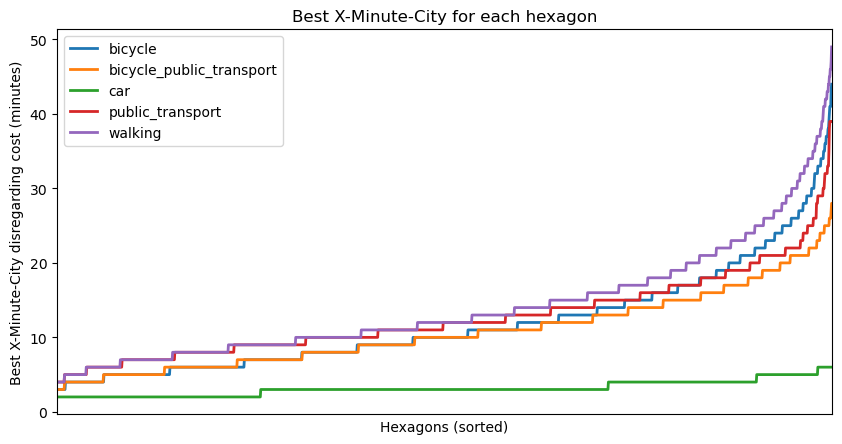

In [23]:
fig, ax = plt.subplots(figsize=(10, 5))
plot_sorted_grouped_data(profiles_df, "scenario", "optimal_in_minutes", ax)
ax.set_title('Best X-Minute-City for each hexagon')
ax.set_ylabel('Best X-Minute-City disregarding cost (minutes)')
ax.set_xlabel('Hexagons (sorted)')
plt.show()

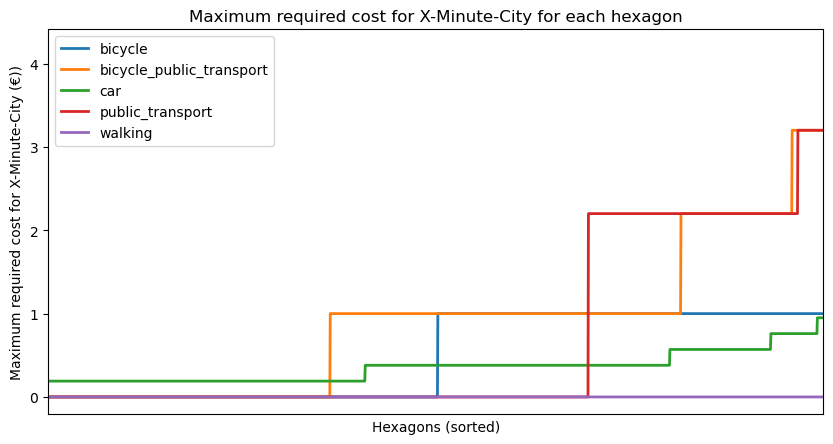

In [24]:
fig, ax = plt.subplots(figsize=(10, 5))
plot_sorted_grouped_data(
    profiles_df, "scenario", "required_cost_for_optimal_in_euro", ax
)
ax.set_title("Maximum required cost for X-Minute-City for each hexagon")
ax.set_ylabel("Maximum required cost for X-Minute-City (€))")
ax.set_xlabel("Hexagons (sorted)")
plt.show()


In [25]:
import numpy as np
no_inf_profiles_df = profiles_df[np.isinf(profiles_df[cost_columns]).sum(axis=1) == 0]
no_inf_profiles_df
# np.isinf(profiles_df[cost_columns]).sum(axis=1)


any_column_different  required_cost_for_optimal  optimal  \
hex_id                                                                      
891fa181003ffff                 False                          0    720.0   
891fa181007ffff                 False                          0    960.0   
891fa18100bffff                  True                        220    720.0   
891fa18100fffff                 False                          0   1260.0   
891fa181013ffff                  True                        220    540.0   
...                               ...                        ...      ...   
891fa564bdbffff                 False                          0   1140.0   
891fa565923ffff                 False                          0   1680.0   
891fa565927ffff                  True                        220   1140.0   
891fa56592bffff                  True                        220   1680.0   
891fa56592fffff                  True                        320   1140.0   

                                 scenario  required_cost_for_optimal_in_euro  \
hex_id                                                                         
891fa181003ffff          public_transport                                0.0   
891fa181007ffff          public_transport                                0.0   
891fa18100bffff          public_transport                                2.2   
891fa18100fffff          public_transport                                0.0   
891fa181013ffff          public_transport                                2.2   
...                                   ...                                ...   
891fa564bdbffff  bicycle_public_transport                                0.0   
891fa565923ffff  bicycle_public_transport                                0.0   
891fa565927ffff  bicycle_public_transport                                2.2   
891fa56592bffff  bicycle_public_transport                                2.2   
891fa56592fffff  bicycle_public_transport                                3.2   

                 optimal_in_minutes  cost_0  cost_19  cost_38  cost_57  \
hex_id                                                                   
891fa181003ffff                12.0   720.0    720.0    720.0    720.0   
891fa181007ffff                16.0   960.0    960.0    960.0    960.0   
891fa18100bffff                12.0   900.0    900.0    900.0    900.0   
891fa18100fffff                21.0  1260.0   1260.0   1260.0   1260.0   
891fa181013ffff                 9.0   600.0    600.0    600.0    600.0   
...                             ...     ...      ...      ...      ...   
891fa564bdbffff                19.0  1140.0   1140.0   1140.0   1140.0   
891fa565923ffff                28.0  1680.0   1680.0   1680.0   1680.0   
891fa565927ffff                19.0  1500.0   1500.0   1500.0   1500.0   
891fa56592bffff                28.0  1920.0   1920.0   1920.0   1920.0   
891fa56592fffff                19.0  1620.0   1620.0   1620.0   1620.0   

                 cost_76  cost_95  cost_100  cost_114  cost_133  cost_200  \
hex_id                                                                      
891fa181003ffff    720.0    720.0     720.0     720.0     720.0     720.0   
891fa181007ffff    960.0    960.0     960.0     960.0     960.0     960.0   
891fa18100bffff    900.0    900.0     900.0     900.0     900.0     900.0   
891fa18100fffff   1260.0   1260.0    1260.0    1260.0    1260.0    1260.0   
891fa181013ffff    600.0    600.0     600.0     600.0     600.0     600.0   
...                  ...      ...       ...       ...       ...       ...   
891fa564bdbffff   1140.0   1140.0    1140.0    1140.0    1140.0    1140.0   
891fa565923ffff   1680.0   1680.0    1680.0    1680.0    1680.0    1680.0   
891fa565927ffff   1500.0   1500.0    1500.0    1500.0    1500.0    1500.0   
891fa56592bffff   1920.0   1920.0    1920.0    1920.0    1920.0    1920.0   
891fa56592fffff   1620.0   1620.0    1620.0    1620.0    1620.0    1620.0   

         

In [26]:
mean_per_cost_per_scenario = no_inf_profiles_df.groupby("scenario")[cost_columns].mean()
mean_per_cost_per_scenario.columns = [int(column.split("_")[1]) for column in mean_per_cost_per_scenario.columns]

In [27]:
maximum_time = mean_per_cost_per_scenario.T.max(numeric_only=True).max()

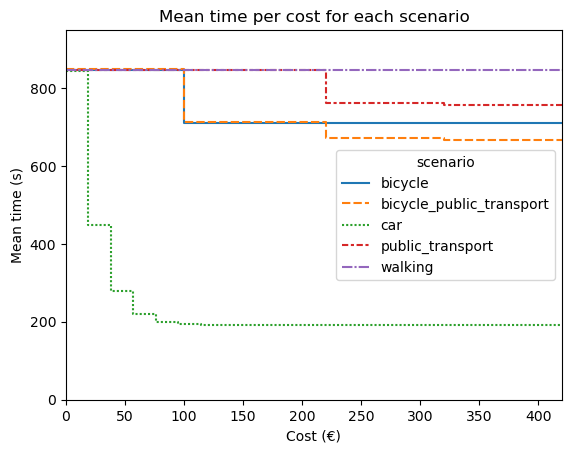

In [28]:
import seaborn as sns
ax = sns.lineplot(data=mean_per_cost_per_scenario.T, drawstyle="steps-post")
# ax = sns.scatterplot(data=mean_per_cost_per_scenario.T)
ax.set_xlim(0, mean_per_cost_per_scenario.T.index.max())
ax.set_ylim(0,maximum_time+100)
ax.set_title("Mean time per cost for each scenario")
ax.set_ylabel("Mean time (s)")
ax.set_xlabel("Cost (€)")
plt.show()

In [29]:
m = folium.Map(location=[50.9375, 6.9603], zoom_start=12)
plot_h3_cells_on_folium(
    profiles_df_per_scenario["bicycle"]["cost_0"].to_dict(),
    m,
    color="red",
    popup_callback=lambda x: strtime.seconds_to_str_time(int(x)),
)
m

In [30]:
m = folium.Map(location=[50.9375, 6.9603], zoom_start=12)
plot_h3_cells_on_folium(
    profiles_df_per_scenario["car"]["optimal"].to_dict(),
    m,
    color="red",
    popup_callback=lambda x: strtime.seconds_to_str_time(int(x)),
)
m


In [31]:
m = folium.Map(location=[50.9375, 6.9603], zoom_start=12)
plot_h3_cells_on_folium(
    (profiles_df_per_scenario["car"]["required_cost_for_optimal"]).to_dict(),
    m,
    color="blue",
    popup_callback=lambda x: f"cost: {x/100:.2f}€",
)
m